In [31]:
#install.packages("mltools")
#install.packages("RcmdrMisc")
#install.packages("glmnet")
#install.packages("caret")
install.packages("mgcv")

library(caret)     #preprocess and scale
#library(mltools)  #subselection
library(RcmdrMisc) #subselection
library(glmnet)    #ridge
library(mgcv)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: nlme
This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.


In [2]:
setwd("~/Documents/STK-IN4300/oblig2-2")

## Problem 1, regression:

In [3]:
data <- read.csv(file = 'qsar_aquatic_toxicity.csv', header = FALSE, sep=";")
colnames(data) = cbind("TPSA", "SAacc", "H050", "MLOGP", "RDCHI", "GATS1p", "nN", "C040", "LC50")
#why is the data frame unlabeled and the entries seperated by ";"?

summary(data)

      TPSA            SAacc             H050             MLOGP       
 Min.   :  0.00   Min.   :  0.00   Min.   : 0.0000   Min.   :-6.446  
 1st Qu.: 15.79   1st Qu.: 11.00   1st Qu.: 0.0000   1st Qu.: 1.232  
 Median : 40.46   Median : 42.68   Median : 0.0000   Median : 2.273  
 Mean   : 48.47   Mean   : 58.87   Mean   : 0.9377   Mean   : 2.313  
 3rd Qu.: 70.02   3rd Qu.: 77.49   3rd Qu.: 1.0000   3rd Qu.: 3.393  
 Max.   :347.32   Max.   :571.95   Max.   :18.0000   Max.   : 9.148  
     RDCHI           GATS1p            nN              C040        
 Min.   :1.000   Min.   :0.281   Min.   : 0.000   Min.   : 0.0000  
 1st Qu.:1.975   1st Qu.:0.737   1st Qu.: 0.000   1st Qu.: 0.0000  
 Median :2.344   Median :1.020   Median : 1.000   Median : 0.0000  
 Mean   :2.492   Mean   :1.046   Mean   : 1.004   Mean   : 0.3535  
 3rd Qu.:2.911   3rd Qu.:1.266   3rd Qu.: 2.000   3rd Qu.: 0.0000  
 Max.   :6.439   Max.   :2.500   Max.   :11.000   Max.   :11.0000  
      LC50       
 Min.   : 0.122 

By inspection, some factors of the counting features occure very rarly. These are promptly removed, becaue it can lead to problems if these factors appear in the test data, but not the train data.

In [4]:
data <- data[data$H050<6,]
data <- data[data$nN<6,]
data <- data[data$C040 < 3,]

### Train-Test Split:

In [5]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

## Model with numeric features

In [6]:
lm_numeric_features <- lm(LC50 ~ ., data = train)

test_mse <- mean((test$LC50 - predict.lm(lm_numeric_features, test))^2)
print(paste0("MSE on test data for model with numeric features: ", test_mse))
summary(lm_numeric_features)

[1] "MSE on test data for model with numeric features: 1.55471329781609"



Call:
lm(formula = LC50 ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6160 -0.8128 -0.1343  0.6174  3.8872 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.768081   0.304962   9.077  < 2e-16 ***
TPSA         0.030000   0.003575   8.392 1.74e-15 ***
SAacc       -0.016395   0.002706  -6.060 3.96e-09 ***
H050        -0.115121   0.086407  -1.332  0.18374    
MLOGP        0.430367   0.082784   5.199 3.66e-07 ***
RDCHI        0.502127   0.169634   2.960  0.00331 ** 
GATS1p      -0.498033   0.199199  -2.500  0.01293 *  
nN          -0.160385   0.069173  -2.319  0.02107 *  
C040        -0.123879   0.126760  -0.977  0.32920    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.16 on 309 degrees of freedom
Multiple R-squared:  0.4923,	Adjusted R-squared:  0.4791 
F-statistic: 37.45 on 8 and 309 DF,  p-value: < 2.2e-16


## Model with categorical features

In [7]:
train$H050 <- as.factor(train$H050)
test$H050 <- as.factor(test$H050)

train$nN <- as.factor(train$nN)
test$nN <- as.factor(test$nN)

train$C040 <- as.factor(train$C040)
test$C040 <- as.factor(test$C040)

In [8]:
lm_factor_features <- lm(LC50 ~ ., data = train)

test_mse <- mean((test$LC50 - predict.lm(lm_factor_features, test))^2)
print(paste0("MSE on test data for model with factor features: ", test_mse))
summary(lm_factor_features)

[1] "MSE on test data for model with factor features: 1.50345969915486"



Call:
lm(formula = LC50 ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9250 -0.7585 -0.0751  0.6081  4.0081 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.739701   0.317755   8.622 3.86e-16 ***
TPSA         0.028896   0.003647   7.924 4.55e-14 ***
SAacc       -0.016259   0.002885  -5.636 4.00e-08 ***
H0501       -0.107165   0.184973  -0.579  0.56278    
H0502       -0.430947   0.230076  -1.873  0.06203 .  
H0503       -0.465218   0.417858  -1.113  0.26645    
H0504        0.124275   0.486665   0.255  0.79862    
H0505       -0.167273   0.771160  -0.217  0.82843    
MLOGP        0.431470   0.085405   5.052 7.61e-07 ***
RDCHI        0.494350   0.176183   2.806  0.00535 ** 
GATS1p      -0.513390   0.203741  -2.520  0.01226 *  
nN1          0.238308   0.169115   1.409  0.15983    
nN2         -0.263349   0.231622  -1.137  0.25645    
nN3         -0.183813   0.328837  -0.559  0.57659    
nN4         -0.837986   0.482289  -1.

Comparing the models, we see that the numeric features of the first model are more significant than the categorical features of the second model. This is because in splitting the numeric features into categorical features, we get more parameters to estimate. The training examples will be split amoung the new categorical features, resulting in less data for estimation per parameter and thus less significance. 

Still, the MSE of the second ended up lower. This might be a result of the fact that our model is in a sense regularized, in the sense that categories in the data set that appeared very rearly was removed. These would 
result in the least significant parameters, but also caused bugs in R in the case that a category appeared in the test data, but not the training data.

On the other hand, having more parameters, the second model is more expressive. It's not given that a numeric 
representation of the counting features is justified. This enforces a linear structure, in the sense that two atoms contribute twice as much to the response as one atom. This might be far from the true nature of the system, and categorical features might be more appropriate.

### Repeat 200 times

In [9]:
set.seed(42)
mse_numeric = 0
mse_factor = 0
for (i in 1:200)
{
    n = nrow(data)
    train_size = floor(0.75*n)
    train_idx = sample(seq_len(n), size = train_size)

    train = data[train_idx,]
    test = data[-train_idx,]
    
    #numeric features
    lm_numeric_features <- lm(LC50 ~ ., data = train)
    mse_numeric = mse_numeric + mean((test$LC50 - predict.lm(lm_numeric_features, test))^2)
    
    
    #factor features
    train$H050 <- as.factor(train$H050)
    train$nN <- as.factor(train$nN)
    train$C040 <- as.factor(train$C040)
    
    
    test$H050 <- as.factor(test$H050)
    test$nN <- as.factor(test$nN)
    test$C040 <- as.factor(test$C040)
    
    
    
    lm_factor_features <- lm(LC50 ~ ., data = train)
    mse_factor = mse_factor + mean((test$LC50 - predict.lm(lm_factor_features, test))^2) 
}
print(paste0("Average MSE on test data for model with numeric features: ", mse_numeric/200))
print(paste0("Average MSE on test data for model with factor features: ", mse_factor/200))


[1] "Average MSE on test data for model with numeric features: 1.44059515148494"
[1] "Average MSE on test data for model with factor features: 1.45521686010559"


Averaging the previous procedure over 200 runs, the models perform approximatly equally good.

## Subset selection

In [10]:
data <- read.csv(file = 'qsar_aquatic_toxicity.csv', header = FALSE, sep=";")
colnames(data) = cbind("TPSA", "SAacc", "H050", "MLOGP", "RDCHI", "GATS1p", "nN", "C040", "LC50")

In [11]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

In [12]:
full_model = lm(LC50 ~ ., data = train)

forwardAIC_model = stepwise(full_model, direction = "forward", criterion = "AIC", trace=0)
backwardAIC_model = stepwise(full_model, direction = "backward", criterion = "AIC", trace=0)
summary(forwardAIC_model)
summary(backwardAIC_model)

forwardBIC_model = stepwise(full_model, direction = "forward", criterion = "BIC", trace=0)
backwardBIC_model = stepwise(full_model, direction = "backward", criterion = "BIC", trace=0)
summary(forwardBIC_model)
summary(backwardBIC_model)




Direction:  forward
Criterion:  AIC 


Direction:  backward
Criterion:  AIC 




Call:
lm(formula = LC50 ~ MLOGP + TPSA + SAacc + nN + RDCHI + GATS1p, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7898 -0.7416 -0.0908  0.6728  3.5676 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.498946   0.280097   8.922  < 2e-16 ***
MLOGP        0.389424   0.075410   5.164 4.25e-07 ***
TPSA         0.028554   0.003123   9.142  < 2e-16 ***
SAacc       -0.015683   0.001975  -7.942 3.41e-14 ***
nN          -0.262371   0.060172  -4.360 1.75e-05 ***
RDCHI        0.677960   0.166333   4.076 5.79e-05 ***
GATS1p      -0.564347   0.171382  -3.293   0.0011 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.126 on 320 degrees of freedom
Multiple R-squared:  0.5296,	Adjusted R-squared:  0.5208 
F-statistic: 60.05 on 6 and 320 DF,  p-value: < 2.2e-16



Call:
lm(formula = LC50 ~ TPSA + SAacc + MLOGP + RDCHI + GATS1p + nN, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7898 -0.7416 -0.0908  0.6728  3.5676 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.498946   0.280097   8.922  < 2e-16 ***
TPSA         0.028554   0.003123   9.142  < 2e-16 ***
SAacc       -0.015683   0.001975  -7.942 3.41e-14 ***
MLOGP        0.389424   0.075410   5.164 4.25e-07 ***
RDCHI        0.677960   0.166333   4.076 5.79e-05 ***
GATS1p      -0.564347   0.171382  -3.293   0.0011 ** 
nN          -0.262371   0.060172  -4.360 1.75e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.126 on 320 degrees of freedom
Multiple R-squared:  0.5296,	Adjusted R-squared:  0.5208 
F-statistic: 60.05 on 6 and 320 DF,  p-value: < 2.2e-16



Direction:  forward
Criterion:  BIC 


Direction:  backward
Criterion:  BIC 




Call:
lm(formula = LC50 ~ MLOGP + TPSA + SAacc + nN + RDCHI + GATS1p, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7898 -0.7416 -0.0908  0.6728  3.5676 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.498946   0.280097   8.922  < 2e-16 ***
MLOGP        0.389424   0.075410   5.164 4.25e-07 ***
TPSA         0.028554   0.003123   9.142  < 2e-16 ***
SAacc       -0.015683   0.001975  -7.942 3.41e-14 ***
nN          -0.262371   0.060172  -4.360 1.75e-05 ***
RDCHI        0.677960   0.166333   4.076 5.79e-05 ***
GATS1p      -0.564347   0.171382  -3.293   0.0011 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.126 on 320 degrees of freedom
Multiple R-squared:  0.5296,	Adjusted R-squared:  0.5208 
F-statistic: 60.05 on 6 and 320 DF,  p-value: < 2.2e-16



Call:
lm(formula = LC50 ~ TPSA + SAacc + MLOGP + RDCHI + GATS1p + nN, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7898 -0.7416 -0.0908  0.6728  3.5676 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.498946   0.280097   8.922  < 2e-16 ***
TPSA         0.028554   0.003123   9.142  < 2e-16 ***
SAacc       -0.015683   0.001975  -7.942 3.41e-14 ***
MLOGP        0.389424   0.075410   5.164 4.25e-07 ***
RDCHI        0.677960   0.166333   4.076 5.79e-05 ***
GATS1p      -0.564347   0.171382  -3.293   0.0011 ** 
nN          -0.262371   0.060172  -4.360 1.75e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.126 on 320 degrees of freedom
Multiple R-squared:  0.5296,	Adjusted R-squared:  0.5208 
F-statistic: 60.05 on 6 and 320 DF,  p-value: < 2.2e-16


Forward selection and backward elimination both produce a sequence of models with different number of features.
Forward selection starts with the empty model, and in sequence adds the most significant feature. Backwards elimination starts with the full model, and removes the least significant feature. These are greedy searches. Consider forward selection: It starts by adding the most significant feature, but this does not necesarily mean that this feature is part of the best (exhaustive) subset. Even though the first feature is most significant in isolation, it might be less significant in combination with other features. This is due to correlations among features. 

In this example, all methods produced the same model. This could mean that there is little correlation among the features, based on what was discussed earlier.

## Ridge regression

In [25]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

x_train = as.matrix(train[,-9])
y_train = as.matrix(train$LC50)

x_test = as.matrix(test[,-9])
y_test = as.matrix(test$LC50)

scaler = preProcess(x_train)
x_train = predict(scaler, x_train)
x_test = predict(scaler, x_test)

grid = 10^seq(-5, -1, length = 20)

### CV, 10-fold

[1] "Best lambda found with CV: 1e-05"
[1] "MSE train: 1,23395790262481"
[1] "MSE test: 1,75684730589915"


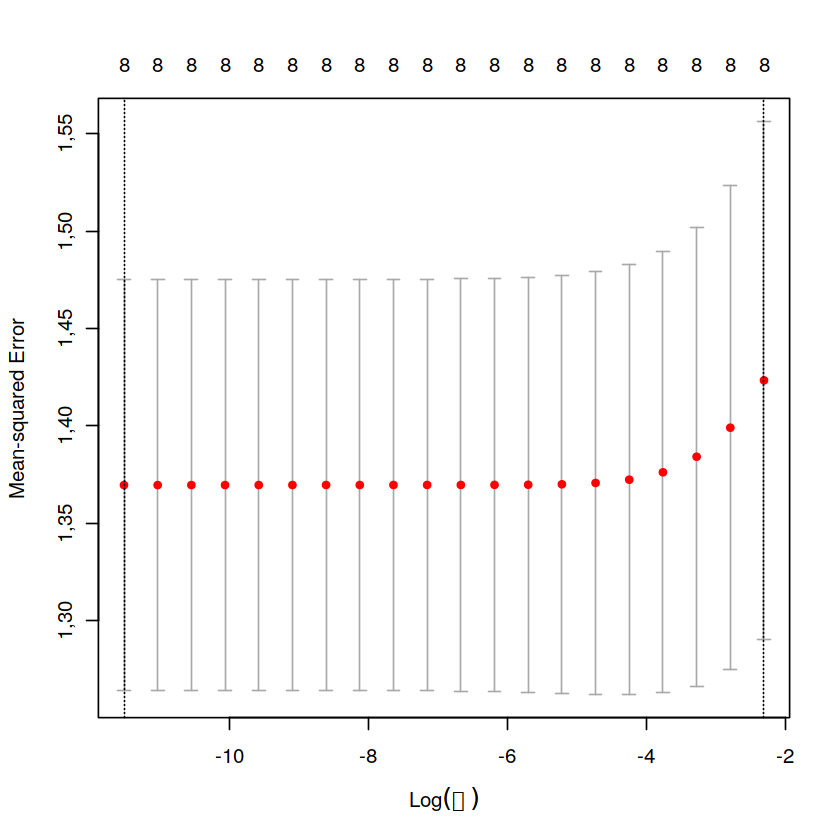

In [26]:
cv_out = cv.glmnet(x_train, y_train, lambda = grid, 
                   type.measure = "deviance", nfolds = 10, trace.it = 0, alpha = 0)

plot(cv_out)
opt_lambda <- cv_out$lambda.min #best lambda
print(paste0("Best lambda found with CV: ", opt_lambda))
fit = cv_out$glmnet.fit #all fitted models

y_predicted_train <- predict(fit, s = opt_lambda, newx = x_train)
mse_train = mean((y_predicted_train - y_train)^2)

y_predicted_test <- predict(fit, s = opt_lambda, newx = x_test)
mse_test = mean((y_predicted_test - y_test)^2)

print(paste0("MSE train: ", mse_train))
print(paste0("MSE test: ", mse_test))

### Bootstrap

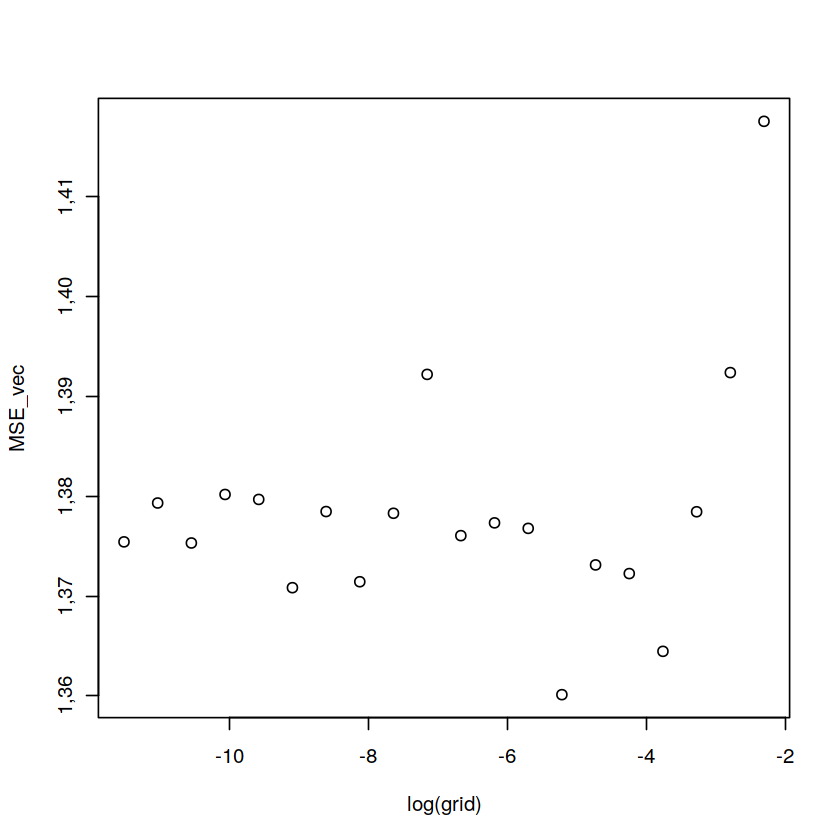

In [27]:
set.seed(42)
n = nrow(x_train)
B = 1000
MSE_vec = rep(0,20)

for (i in 1:20)
{
    MSE = 0
    for (j in 1:B)
    {
        idx = sample(seq_len(n), size = n, replace = TRUE)

        fit = glmnet(x_train[idx,], y_train[idx,], lambda = grid[i], alpha = 0)
        #predict on out of sample
        y_predicted = predict(fit, newx = x_train[-idx,])  
        MSE = MSE + mean((y_predicted - y_train[-idx,])^2)
    }
    MSE_vec[i] = MSE/B
}
plot(log(grid), MSE_vec)

## Smoothing splines

In [32]:
set.seed(42)
n = nrow(data)
train_size = floor(0.6*n)
train_idx = sample(seq_len(n), size = train_size)

train = data[train_idx,]
test = data[-train_idx,]

In [41]:
fit = gam(LC50 ~ s(TPSA, bs="cr") + s(SAacc, bs="cr") + s(H050, bs="cr") + s(MLOGP, bs="cr")
          + s(RDCHI, bs="cr") + s(GATS1p, bs="cr"),
          data=train)

In [ ]:
y_predicted_train = predict(fit, newx = train)
